In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import keras_nlp

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from datetime import datetime
import utils


2024-12-11 21:51:05.017213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 21:51:05.131776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 21:51:05.163311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 21:51:05.360610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 21:51:07.342132: W tensorflow/compiler/tf2

In [2]:
keras.utils.set_random_seed(69)

In [3]:
df = pd.read_csv("../data/clean/dataset_final.csv")
df.head()

,Task,Category
0,delegate task to team,urgent not-important
1,organize the file for the company-wide audit,urgent important
2,plan time for extracurricular activity,not-urgent important
3,update website content,not-urgent important
4,buy supply for upcoming school project,not-urgent important


# Create Dataset

In [4]:
sentences = df["Task"].to_numpy()
labels = df["Category"].to_numpy()

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(len(dataset))

print(sentences[:10])
print()
print(labels[:10])

I0000 00:00:1733928671.267926    1328 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733928671.551844    1328 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733928671.551934    1328 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733928671.561112    1328 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733928671.561220    1328 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

['delegate task to team' 'organize the file for the company-wide audit'
 'plan time for extracurricular activity' 'update website content'
 'buy supply for upcoming school project' 'be patient with yourself'
 'update student profile' 'organize course syllabus'
 'practice public speaking' 'confirm lunch location and time']

['urgent not-important' 'urgent important' 'not-urgent important'
 'not-urgent important' 'not-urgent important' 'not-urgent important'
 'urgent not-important' 'not-urgent not-important' 'not-urgent important'
 'urgent not-important']


# Hyperparameters

In [5]:
EMBEDDING_DIM = 64
MAX_LENGTH = 74
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

# Split Dataset

In [6]:
train_size = int(len(dataset) * TRAINING_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train_ds = train_ds.batch(NUM_BATCHES)
val_ds = val_ds.batch(NUM_BATCHES)

print(f"There are {len(train_ds)} batches for a total of {NUM_BATCHES*len(train_ds)} elements for training.")
print(f"There are {len(val_ds)} batches for a total of {NUM_BATCHES*len(val_ds)} elements for validation.")

There are 22 batches for a total of 2816 elements for training.
There are 3 batches for a total of 384 elements for validation.


# Vectorize Dataset

In [7]:
train_sentences = train_ds.map(lambda x, _: x)  
train_labels = train_ds.map(lambda _, y: y)

In [8]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_sentences,
    lowercase=True,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    sequence_length=MAX_LENGTH
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary size = {vocab_size}")

2024-12-11 21:51:16.408399: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary size = 526


In [9]:
label_lookup = keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(train_labels)

print(f"Label size = {label_lookup.vocabulary_size()}")

Label size = 4


2024-12-11 21:51:18.972015: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
for x, y in val_ds.take(1):
    sample_string = x[1]

tokenized_string = tokenizer.tokenize(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer.detokenize(tokenized_string)
print(f"The original string: {original_string}")

Tokenized string is [128  46  35  72 318 118 348 519 258   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
The original string: browse study technique [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [11]:
train_ds_vec = train_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))
val_ds_vec = val_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))

for features, labels in train_ds_vec.take(1):
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[ 49 338 216 ...   0   0   0]
 [ 63  44  52 ...   0   0   0]
 [177  45  35 ...   0   0   0]
 ...
 [ 64 280  33 ...   0   0   0]
 [ 97 443 224 ...   0   0   0]
 [ 97 500  66 ...   0   0   0]]
Labels: [3 2 3 2 3 1 1 2 0 0 1 2 3 2 3 2 0 2 1 0 1 0 1 3 1 2 3 3 0 0 0 1 0 2 0 2 2
 1 1 2 1 0 3 3 3 2 1 0 3 0 3 2 0 1 1 1 0 0 2 2 2 2 3 1 3 2 1 3 3 1 2 3 3 3
 1 2 0 1 3 1 1 1 3 2 2 0 0 1 0 1 0 1 2 1 0 3 3 1 0 3 0 3 1 2 1 1 2 3 0 3 2
 2 0 2 3 2 0 2 2 1 2 1 2 2 1 3 2 0]


2024-12-11 21:51:20.192691: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Train

In [12]:
model = keras.Sequential([
    keras.Input(shape=(MAX_LENGTH,)),
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, "relu"),
    keras.layers.Dense(4, "softmax"),
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 74, 64)         │        33,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,652 (936.14 KB)

 Trainable params: 239,652 (936.14 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_ds_vec, epochs=100, validation_data=val_ds_vec)

Epoch 1/100


2024-12-11 21:51:25.409929: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3174 - loss: 1.3764 - val_accuracy: 0.4554 - val_loss: 1.2793
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4522 - loss: 1.2409 - val_accuracy: 0.6040 - val_loss: 0.9668
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6206 - loss: 0.9222 - val_accuracy: 0.6766 - val_loss: 0.8092
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7090 - loss: 0.7441 - val_accuracy: 0.7558 - val_loss: 0.6467
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7548 - loss: 0.6376 - val_accuracy: 0.7855 - val_loss: 0.5769
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7836 - loss: 0.5745 - val_accuracy: 0.7954 - val_loss: 0.5311
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8079 - loss: 0.5384 - val_accuracy: 0.8086 - val_loss: 0.5203
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8189 - loss: 0.4855 - val_accuracy: 0.7888 - val_l

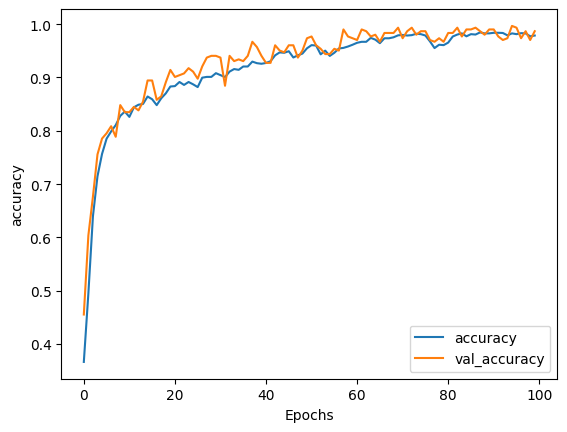

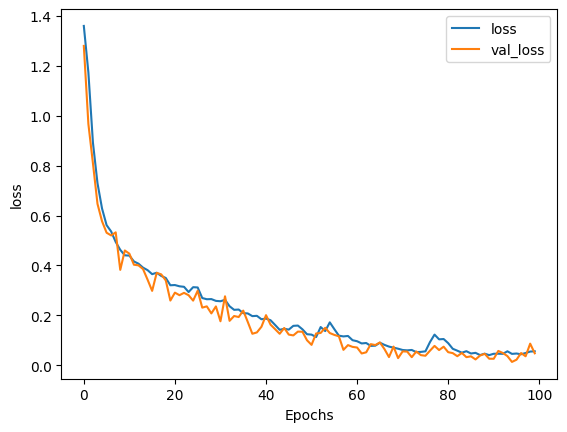

In [14]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test

In [15]:
task = "finish the assignment that's due tonight"
print(f"Input: {task}")

task = utils.lemmatize(task)
print(f"Lemmatized input: {task}")

task_vec = tokenizer(task)
print(f"Vectorized input: {tokenizer.detokenize(task_vec)}")
print(f"\t{[x for x in task_vec.numpy()]}\n")
task_vec = np.reshape(task_vec, (1, len(task_vec)))

prediction = model.predict(task_vec)[0]
print(f"Prediction vector: {prediction}")

label_vocab = label_lookup.get_vocabulary()
for label, probability in zip(label_vocab, prediction):
    percentage = probability * 100
    print(f"\t{label}: {percentage:.5f}%")

best = label_vocab[np.argmax(prediction)]
print(f"Prediction: {best}")

Input: finish the assignment that's due tonight
Lemmatized input: finish the assignment that's due tonight
Vectorized input: finish the assignment that ' s due tonight [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
	[365, 44, 121, 35, 220, 194, 3, 34, 302, 230, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Prediction vector: [8.708488e-13 8.198272e-12 1.000000e+00 9.546365e-12]
	not-urgent not-important: 0.00000%
	not-urgent important: 0.00000%
	urgent important: 100.00000

# Save

In [16]:
packed_model = keras.Sequential([
    tokenizer,
    label_lookup,
    model,
])

packed_model.built = True
now = datetime.now().strftime(r"%Y-%m-%d_%H-%M-%S")
packed_model.save(f"../model/{now}.keras")